In [4]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import altair as alt
alt.data_transformers.disable_max_rows()
alt.display.renderers.enable('svg')
import matplotlib.pyplot as plt

import act
import act.discovery, act.io

import metpy.calc, metpy.constants
from metpy.units import units
import glob
from tqdm import tqdm
from sublimpy import utils

import altair as alt
import pandas as pd
import numpy as np
import tqdm
from joblib import Parallel, delayed
import datetime as dt

# Observations

## SOS towers

In [5]:
sos_fn = '../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_pf10.parquet'
sos_df = pd.read_parquet(sos_fn)

# Calculate for one file at a time

In [6]:
def get_anisotropy_invariant_map_points(file, tower_height = '3m_c'):
    sos_ds = xr.open_dataset(file)
    x_B_ls = []
    y_B_ls = []
    for i in range(0, len(sos_ds['u_u__20m_c'])):
        u11 = sos_ds[f'u_u__{tower_height}'].values[i]
        u21 = sos_ds[f'u_v__{tower_height}'].values[i]
        u31 = sos_ds[f'u_w__{tower_height}'].values[i]

        u12 = sos_ds[f'u_v__{tower_height}'].values[i]
        u22 = sos_ds[f'v_v__{tower_height}'].values[i]
        u32 = sos_ds[f'v_w__{tower_height}'].values[i]

        u13 = sos_ds[f'u_w__{tower_height}'].values[i]
        u23 = sos_ds[f'v_w__{tower_height}'].values[i]
        u33 = sos_ds[f'w_w__{tower_height}'].values[i]

        re_stress_tensor = np.array([
            np.array([u11, u12, u13]),
            np.array([u21, u22, u23]),
            np.array([u31, u32, u33]),
        ])
        tke = (1/2)*(re_stress_tensor[0,0] + re_stress_tensor[1,1] + re_stress_tensor[2,2])
        normalization_factor = 2*tke
        kronecker_delta = np.array([
            np.array([1, 0, 0]),
            np.array([0, 1, 0]),
            np.array([0, 0, 1]),
        ])
        b_ij = (re_stress_tensor / normalization_factor) - (1 / 3)*kronecker_delta
        [eigenvalue_1, eigenvalue_2, eigenvalue_3] = np.linalg.eig(b_ij).eigenvalues
        # IS THIS CORRECT? In the Stiperski paper, does "first" eigenvalue mean the largest eigenvalue?
        # note that np.linalg.eig(...).eigenvalues doe NOT return eigenvalues in order
        [eigenvalue_1, eigenvalue_2, eigenvalue_3] = reversed(sorted([eigenvalue_1, eigenvalue_2, eigenvalue_3]))
        assert (eigenvalue_1>eigenvalue_2 and eigenvalue_2 > eigenvalue_3)
        C_1c = eigenvalue_1 - eigenvalue_2
        C_2c = 2*(eigenvalue_2 - eigenvalue_3)
        C_3c = 3*eigenvalue_3 + 1

        x_B = C_1c + C_3c*(1 / 2)
        y_B = C_3c * np.sqrt(3) / 2

        x_B_ls.append(x_B)
        y_B_ls.append(y_B)
    return x_B_ls, y_B_ls, list(sos_ds.time.values)

In [7]:
base_string = "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_"
x_B_ls_0415, y_B_ls_0415, time_0415 = get_anisotropy_invariant_map_points(f'{base_string}20230415.nc')
x_B_ls_0418, y_B_ls_0418, time_0418 = get_anisotropy_invariant_map_points(f'{base_string}20230418.nc')
x_B_ls_1221, y_B_ls_1221, time_1221 = get_anisotropy_invariant_map_points(f'{base_string}20221221.nc')
x_B_ls_0202, y_B_ls_0202, time_0202 = get_anisotropy_invariant_map_points(f'{base_string}20230202.nc')

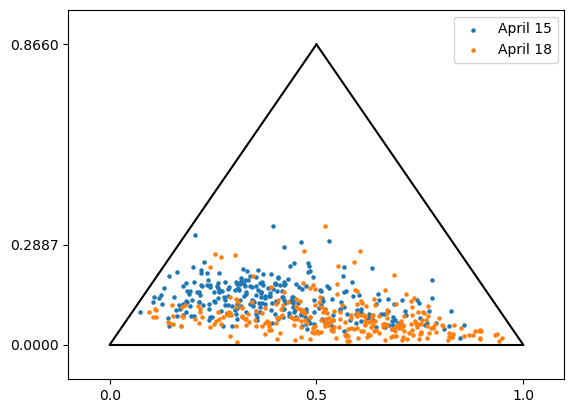

In [35]:
# plt.scatter(x_B_ls_0202, y_B_ls_0202, label = 'Feb. 2', s=5)
plt.scatter(x_B_ls_0415, y_B_ls_0415, label = 'April 15', s=5)
plt.scatter(x_B_ls_0418, y_B_ls_0418, label = 'April 18', s=5)
# plt.scatter(x_B_ls_1221, y_B_ls_1221, label = 'Dec 21', s=5)
plt.ylim(-0.1, np.sqrt(3) / 2 + 0.1)
plt.xlim(0 - 0.1, 1 + 0.1)

plt.plot([0, 0.5], [0, np.sqrt(3)/2], 'black')
plt.plot([0.5, 1], [np.sqrt(3)/2, 0], 'black')
plt.plot([0,1], [0, 0], 'black')
plt.xticks([0, 0.5, 1])
plt.yticks([0, np.sqrt(3)/6, np.sqrt(3)/2])
plt.legend()

# Calculate for all files, for all ECs above 2m

In [9]:
files = glob.glob("/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/*.nc")

In [10]:
import tqdm
from joblib import Parallel, delayed


def process_file(file):
    x_B_ls_local = []
    y_B_ls_local = []
    time_ls_local = []
    for h_t in [
        '3m_c', '5m_c', '10m_c', '15m_c', '20m_c',
        '3m_d', '10m_d',
        '3m_uw', '10m_uw',
        '3m_ue', '10m_ue',
    ]:
        try:
            x_B, y_B, time = get_anisotropy_invariant_map_points(file, h_t)
            x_B_ls_local.append(x_B)
            y_B_ls_local.append(y_B)
            time_ls_local.append(time)
        except:
            pass
    return pd.DataFrame({
        'x':        np.array(x_B_ls_local).flatten(),
        'y':        np.array(y_B_ls_local).flatten(),
        'time':     np.array(time_ls_local).flatten(),
    })

results = Parallel(n_jobs=-1)(delayed(process_file)(file) for file in tqdm.tqdm(files))

100%|██████████| 231/231 [00:53<00:00,  4.29it/s]


In [11]:
results_df = pd.concat(results)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_2537/3354366884.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat(results)


In [12]:
results_df

,x,y,time
0,0.289323,0.107093,2023-05-29 00:02:30
1,0.545027,0.084221,2023-05-29 00:07:30
2,0.378524,0.080582,2023-05-29 00:12:30
3,0.456905,0.119151,2023-05-29 00:17:30
4,0.487524,0.154630,2023-05-29 00:22:30
...,...,...,...
3163,0.415567,0.078269,2023-01-12 23:37:30
3164,0.818203,0.172984,2023-01-12 23:42:30
3165,0.629319,0.090158,2023-01-12 23:47:30
3166,0.870610,0.040012,2023-01-12 23:52:30


In [13]:
triangle = alt.Chart(pd.DataFrame({
    'x': [0, 0.5, 1, 0],
    'y': [0, np.sqrt(3)/2, 0, 0],
    'order': [1, 2, 3, 4]
})).mark_line(color='black').encode(
    x='x',
    y='y',
    order='order'
)

hist2d = alt.Chart(
    results_df
).mark_rect().encode(
    alt.X('x:Q').scale(clamp=True, domain=[0 - 0.1, 1 + 0.1]).bin(step=0.01),
    alt.Y('y:Q').scale(clamp=True, domain=[-0.1, np.sqrt(3) / 2 + 0.1]).bin(step=0.01),
    # color=alt.Color('label', legend=alt.Legend(title="Date"))
    alt.Color('count()', scale=alt.Scale(scheme='viridis'))
).properties(
    title='Scatter Plot'
)

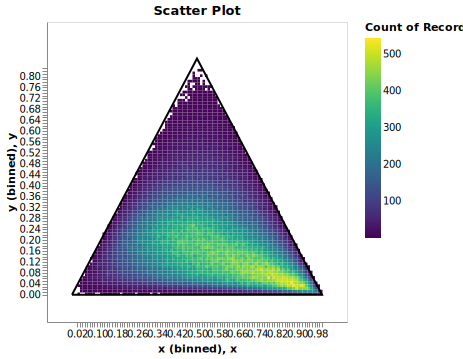

In [14]:
hist2d + triangle

In [29]:
along_valley_wind_times = pd.read_parquet("along_valley_wind_times.parquet").set_index(0)
cross_valley_wind_times = pd.read_parquet("cross_valley_wind_times.parquet").set_index(0)

cross_valley_wind_times = cross_valley_wind_times.resample('5min').ffill().index + dt.timedelta(minutes=2, seconds=30)
along_valley_wind_times = along_valley_wind_times.resample('5min').ffill().index + dt.timedelta(minutes=2, seconds=30)

In [41]:
hist2d = alt.Chart(
    results_df[results_df.time.isin(cross_valley_wind_times)]
).mark_rect().encode(
    alt.X('x:Q').scale(clamp=True, domain=[0 - 0.1, 1 + 0.1]).bin(step=0.01),
    alt.Y('y:Q').scale(clamp=True, domain=[-0.1, np.sqrt(3) / 2 + 0.1]).bin(step=0.01),
    # color=alt.Color('label', legend=alt.Legend(title="Date"))
    alt.Color('count()', scale=alt.Scale(scheme='viridis'))
).properties(
    title='During cross valley synoptic_winds'
)

cross_valley_scatterplot = (hist2d + triangle)

hist2d = alt.Chart(
    results_df[results_df.time.isin(along_valley_wind_times)]
).mark_rect().encode(
    alt.X('x:Q').scale(clamp=True, domain=[0 - 0.1, 1 + 0.1]).bin(step=0.01),
    alt.Y('y:Q').scale(clamp=True, domain=[-0.1, np.sqrt(3) / 2 + 0.1]).bin(step=0.01),
    # color=alt.Color('label', legend=alt.Legend(title="Date"))
    alt.Color('count()', scale=alt.Scale(scheme='viridis'))
).properties(
    title='During along valley synoptic_winds'
)

along_valley_scatterplot = (hist2d + triangle)

In [42]:
cross_valley_scatterplot | along_valley_scatterplot

# Examine transport of momentum fluxes (3rd moments)

In [114]:
sos_ds = xr.open_dataset("../paper1/process_slow_data/sos_ds_temp_storage_30min_straightup.cdf")

In [118]:
w_w_w__3m_c = sos_ds['w_w_w__3m_c'].to_dataframe()

In [71]:
from sublimpy import extrautils

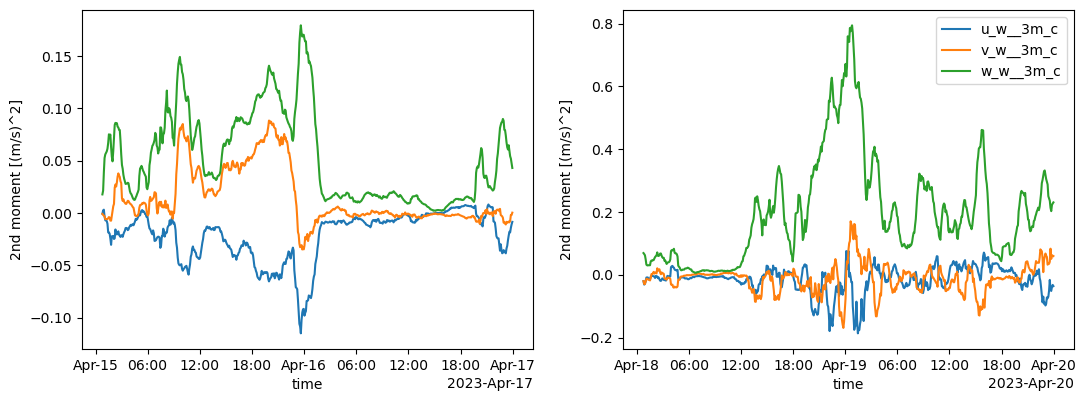

In [94]:


fig, axes = plt.subplots(1,2, figsize=(12.8, 4.4))

ds_5min = xr.open_mfdataset([f'{base_string}20230415.nc', f'{base_string}20230416.nc'])
ds_5min['u_w__3m_c'].rolling(time=10).mean().plot(label='u_w__3m_c', ax=axes[0])
ds_5min['v_w__3m_c'].rolling(time=10).mean().plot(label='v_w__3m_c', ax=axes[0])
ds_5min['w_w__3m_c'].rolling(time=10).mean().plot(label='w_w__3m_c', ax=axes[0])

ds_5min = xr.open_mfdataset([f'{base_string}20230418.nc', f'{base_string}20230419.nc'])
ds_5min['u_w__3m_c'].rolling(time=10).mean().plot(label='u_w__3m_c', ax=axes[1])
ds_5min['v_w__3m_c'].rolling(time=10).mean().plot(label='v_w__3m_c', ax=axes[1])
ds_5min['w_w__3m_c'].rolling(time=10).mean().plot(label='w_w__3m_c', ax=axes[1])
plt.legend()

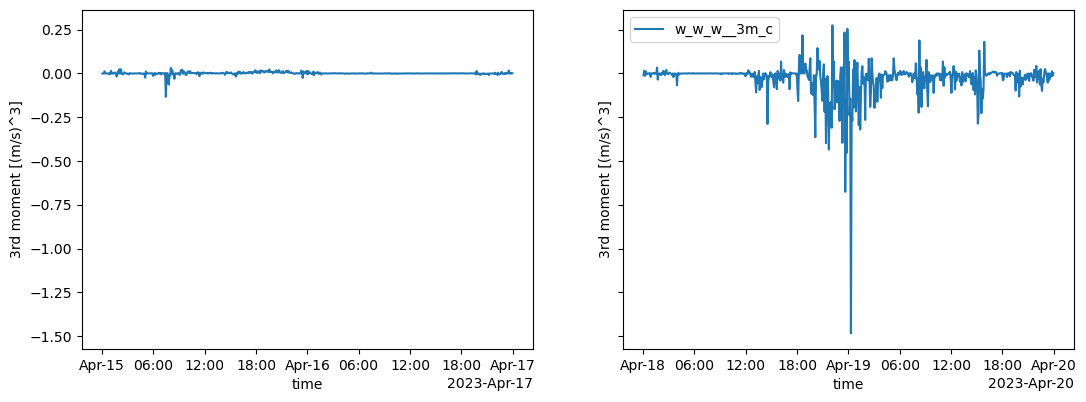

In [137]:
fig, axes = plt.subplots(1,2, figsize=(12.8, 4.4), sharey=True)

ds_5min = xr.open_mfdataset([f'{base_string}20230415.nc', f'{base_string}20230416.nc'])
# ds _5min['u_w_w__3m_c'].plot(label='u_w_w__3m_c', ax=axes[0])
# ds_5min['v_w_w__3m_c'].plot(label='v_w_w__3m_c', ax=axes[0])
ds_5min['w_w_w__3m_c'].plot(label='w_w_w__3m_c', ax=axes[0])

ds_5min = xr.open_mfdataset([f'{base_string}20230418.nc', f'{base_string}20230419.nc'])
# ds _5min['u_w_w__3m_c'].plot(label='u_w_w__3m_c', ax=axes[1])
# ds_5min['v_w_w__3m_c'].plot(label='v_w_w__3m_c', ax=axes[1])
ds_5min['w_w_w__3m_c'].plot(label='w_w_w__3m_c', ax=axes[1])
plt.legend()